# Inicializando

## Limpando diretório e adquirindo dados e funções do git.

In [1]:
# Removing sample_data
!rm -rf sample_data

# Cloning the repo
!git clone https://github.com/lucapcf/BAH_bootcamp

# Moving files from the repo folder to the root directory
!mv BAH_bootcamp/* .

# Removing the original repo folder
!rm -rf BAH_bootcamp

Cloning into 'BAH_bootcamp'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 84 (delta 22), reused 84 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 326.57 KiB | 3.27 MiB/s, done.
Resolving deltas: 100% (22/22), done.


## Procurando licensa

In [2]:
from pathlib import Path
from IPython.display import display, Javascript

# Define the file path
file_path = Path('gurobi.lic')

# Check if the file exists
if not file_path.exists():
    # Trigger a JavaScript alert in the browser
    display(Javascript(f'alert("Erro: A licensa gurobi ({file_path}) não existe na raiz.")'))
else:
    print(f"A licensa '{file_path}' foi encontrada.")

<IPython.core.display.Javascript object>

## Esse passo pode ser pulado, visto que é muito demorado e os arquivos pré-processados já existem. Para testes usar "<example>_sample".

In [3]:
# from pre_processing import extract_symbols, check_integrity
# import datetime as dt

# filepath = "raw_data/NASDAQ_sample.csv"
# exch = 'nasdaq'
# start_date = dt.datetime(2019, 1, 1)
# end_date = dt.datetime(2020, 1, 1)

# filepath1 = extract_symbols(filepath, exch)
# check_integrity(filepath1, start_date, end_date)

## Imports

In [4]:
!pip install squarify
!pip install gurobipy
from IPython.display import clear_output
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.preprocessing import MinMaxScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 16.9 MB/s eta 0:00:00


## Declarando funções

# Funções e constantes

## Análise

In [9]:
def obter_dados(tickers, start_date, end_date):
    """Obtém dados históricos de preços ajustados."""
    dados = pd.DataFrame()
    failed_tickers = []
    i = 0

    for stock in tickers:
        i += 1
        print(f"Downloading data from {stock}... ({i}/{len(tickers)})")
        stock_data = yf.download(stock, start=start_date, end=end_date)[["Adj Close"]]
        if stock_data.empty:
            print(f"No data found for {stock}, skipping...")
            failed_tickers.append(stock)
            continue
        else:
            dados = pd.concat([dados, stock_data], axis=1)

    # Identify columns with NaN values
    columns_with_nan = dados.columns[dados.isna().any()].tolist()
    dados_dropped = dados[columns_with_nan].columns.get_level_values(1).tolist()

    # Remove stocks with NaN values from original DataFrame
    dados_clean = dados.drop(columns=columns_with_nan)
    cleaned_symbols = dados_clean.columns.get_level_values(1).tolist()

    print('Not available in the period requested:', dados_dropped)
    print('Failed download:', failed_tickers)
    return dados_clean['Adj Close']

def calcular_retorno_acumulado_ativo(retornos):
    """Calcula o retorno acumulado de um ativo."""
    return (1 + retornos).cumprod() - 1

def escolhe_pesos(tickers, k):
    """
    Seleciona k tickers aleatórios e atribui pesos normalizados.
    """
    selected_tickers = np.random.choice(tickers, k, replace=False)
    raw_weights = np.random.rand(k)
    normalized_weights = raw_weights / raw_weights.sum()

    ticker_weights = {}
    for symbol, weight in zip(selected_tickers, normalized_weights):
        ticker_weights[symbol] = weight

    return ticker_weights

## Modelo

In [106]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


n_k = [10, 15, 30]
timeout_s = 60
min_weight = 1e-6


def compute_metrics(returns_index, returns_ex, selected_stocks, optimized_weights, k):
    portfolio_returns = (returns_ex[selected_stocks] @ optimized_weights).values

    # Create a DataFrame to align the portfolio and index returns by date
    combined_df = pd.concat([pd.Series(portfolio_returns, index=returns_ex.index, name='Portfolio_Returns'),
                             returns_index], axis=1, join='inner')

    portfolio_returns_aligned = combined_df['Portfolio_Returns']
    returns_index_aligned = combined_df.iloc[:, 1]  # Assuming the index is the second column

    # Compute MSE (Mean Squared Error)
    mse = mean_squared_error(portfolio_returns_aligned, returns_index_aligned)

    # Compute Correlation
    correlation = portfolio_returns_aligned.corr(returns_index_aligned)

    # Compute R-squared (Square of Correlation)
    r_squared = correlation ** 2

    return mse, correlation, r_squared

def plot_metrics(mse_list, correlation_list, r_squared_list, n_k):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the MSE, Correlation, and R-squared values
    ax.plot(n_k, mse_list, label='MSE', marker='o', color='b')
    ax.plot(n_k, correlation_list, label='Correlation', marker='o', color='g')
    ax.plot(n_k, r_squared_list, label='R-squared', marker='o', color='r')

    # Set plot labels and title
    ax.set_xlabel('k (Number of Selected Stocks)', fontsize=12)
    ax.set_ylabel('Metric Value', fontsize=12)
    ax.set_title('Comparison of MSE, Correlation, and R-squared for Different k', fontsize=14)

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.grid(True)
    plt.show()


def plot_portfolio_composition(selected_stocks, optimized_weights, k):
    portfolio_data = pd.DataFrame({
        'Stock': selected_stocks,
        'Weight': optimized_weights * 100
    })

    portfolio_data = portfolio_data.sort_values(by='Weight', ascending=False)

    fig, ax = plt.subplots(figsize=(8, 5))
    fig.patch.set_facecolor('#2A504E')
    ax.set_facecolor('#2A504E')

    squarify.plot(
        sizes=portfolio_data['Weight'],
        label=portfolio_data['Stock'],
        alpha=0.8,
        color=plt.cm.tab20.colors[:len(portfolio_data)],
    )

    plt.axis('off')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.title(f"Composição da Carteira Otimizada para k = {k} (%)", color='white')
    plt.grid(True, color='white')
    plt.show()

def plot_portfolio_performance(selected_stocks, optimized_weights, returns_ex, returns_index, k, index_ticker, index):

    portfolio_returns = (returns_ex[selected_stocks] @ optimized_weights).values

    portfolio_returns_df = pd.DataFrame(
        data=portfolio_returns,
        index=returns_ex.index,
        columns=['Optimized_Portfolio']
    )

    # Prepare the index returns data
    sp100_returns_df = returns_index.copy()
    sp100_returns_df.columns = [index_ticker]

    fig, ax = plt.subplots(figsize=(8, 5))
    fig.patch.set_facecolor('#2A504E')
    ax.set_facecolor('#2A504E')
    plt.plot(portfolio_returns_df.index, portfolio_returns_df['Optimized_Portfolio'], label='Optimized Portfolio', linewidth=2)
    plt.plot(sp100_returns_df.index, sp100_returns_df[index_ticker], label=index, linewidth=2, linestyle='--')

    plt.xlabel('Time', color='white')
    plt.ylabel('Daily Returns', color='white')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.title(f'Comparison of Optimized Portfolio vs. {index} (Raw Returns) for k = {k}', color='white')
    plt.legend()
    plt.grid(True)
    fig.patch.set_facecolor('#2A504E')
    ax.set_facecolor('#2A504E')
    plt.grid(True, color='white')
    plt.show()


def read_license_file(file_path):
    license_data = {}

    try:
        with open(file_path, 'r') as f:
            for line in f:
                if '=' in line:
                    key, value = line.strip().split('=', 1)
                    license_data[key] = value
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' was not found. Please check the file path.")
    except IOError as e:
        raise IOError(f"An error occurred while reading the file '{file_path}': {e}")

    WLSACCESSID = license_data.get('WLSACCESSID')
    WLSSECRET = license_data.get('WLSSECRET')
    LICENSEID = int(license_data.get('LICENSEID'))

    params = {
        "WLSACCESSID": WLSACCESSID,
        "WLSSECRET": WLSSECRET,
        "LICENSEID": LICENSEID,
    }

    return params

def populate_and_solve(m, returns_ex, returns_index, n_stocks_total, n_stocks_selected, time_periods):
    m.setParam('TimeLimit', timeout_s)

    weights = m.addVars(n_stocks_total, lb=min_weight, ub=1, name="weights")

    # Add a constraint to ensure selected stocks have positive weights above a threshold
    # m.addConstrs(weights[j] >= min_weight * select[j] for j in range(n_stocks_total))

    select = m.addVars(n_stocks_total, vtype=GRB.BINARY, name="select")

    # Constraint: Only n stocks are selected
    m.addConstr(gp.quicksum(select[j] for j in range(n_stocks_total)) == n_stocks_selected, "select_n")

    # Constraint: Weights sum to 1 (only for selected stocks)
    m.addConstr(gp.quicksum(weights[j] for j in range(n_stocks_total)) == 1, "weight_sum")

    # Constraint: Set weights to zero for unselected stocks
    for j in range(n_stocks_total):
        m.addConstr(weights[j] <= select[j], f"weight_zero_{j}")


    # Define portfolio return for each period
    portfolio_returns = [
        gp.quicksum(returns_ex.iloc[t, j] * weights[j] for j in range(n_stocks_total))
        for t in range(time_periods)
    ]

    # Objective: Minimize tracking error (sum of squared differences)
    tracking_error = gp.quicksum((portfolio_returns[t] - returns_index.iloc[t, 0]) ** 2 for t in range(time_periods))
    m.setObjective(tracking_error, GRB.MINIMIZE)

    # m.tune()
    m.optimize()

    # Extract the selected stocks and their weights
    selected_stocks = [returns_ex.columns[j] for j in range(n_stocks_total) if select[j].X > 0.5]
    optimized_weights = np.array([weights[j].X for j in range(n_stocks_total) if select[j].X > 0.5])

    # Print the selected stocks and weights
    if m.status == GRB.OPTIMAL:
        print("Optimal Stocks and Weights:")
        for i, stock in enumerate(selected_stocks):
            print(f"Stock {stock}: Weight {optimized_weights[i]:.4f}")
        print(f"Minimum Tracking Error: {m.ObjVal:.4f}")
    else:
        print("No optimal solution found.")

    return selected_stocks, optimized_weights


def get_weights(returns_ex, returns_index, n_stocks_selected):
    n_stocks_total = returns_ex.shape[1]
    time_periods = returns_ex.shape[0]

    filepath = "gurobi.lic"
    params = read_license_file(filepath)

    with gp.Env(params=params) as env:
        with gp.Model(env=env) as model:
            try:
                selected_stocks, optimized_weights = populate_and_solve(model, returns_ex, returns_index, n_stocks_total, n_stocks_selected, time_periods)
                return selected_stocks, optimized_weights
            except Exception as e:
                print(f"An error occurred: {e}")

# Analisando os Datasets

## S&P100

### Inicializando

In [6]:
filepath_sp100 = 'pre_processed_data/bkp_pre_processed_parsed_SP100.csv'
start_date = dt.datetime(2022, 10, 31)
end_date = dt.datetime(2024, 10, 31)
tickers = []

with open(filepath_sp100, 'r') as file:
  for line in file:
    tickers.extend(line.strip().split(','))

percentages_symbols = pd.read_csv('pre_processed_data/sp100_percentages_symbols.csv', encoding='latin-1')

# Obtendo dados dos ativos
dados_nasdaq_nyse = obter_dados(tickers, start_date, end_date)
sp100_dados = obter_dados(['^OEX'], start_date, end_date)
sp500_dados = obter_dados(['^GSPC'], start_date, end_date)

# Calculando retornos
retornos_nasdaq_nyse = dados_nasdaq_nyse.pct_change().dropna()
retornos_sp100 = sp100_dados.pct_change().dropna()
retornos_sp500 = sp500_dados.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Not available in the period requested: []
Failed download: []
Not available in the period requested: []
Failed download: []


[*********************100%***********************]  1 of 1 completed


Not available in the period requested: []
Failed download: []


### Composição do S&P 100

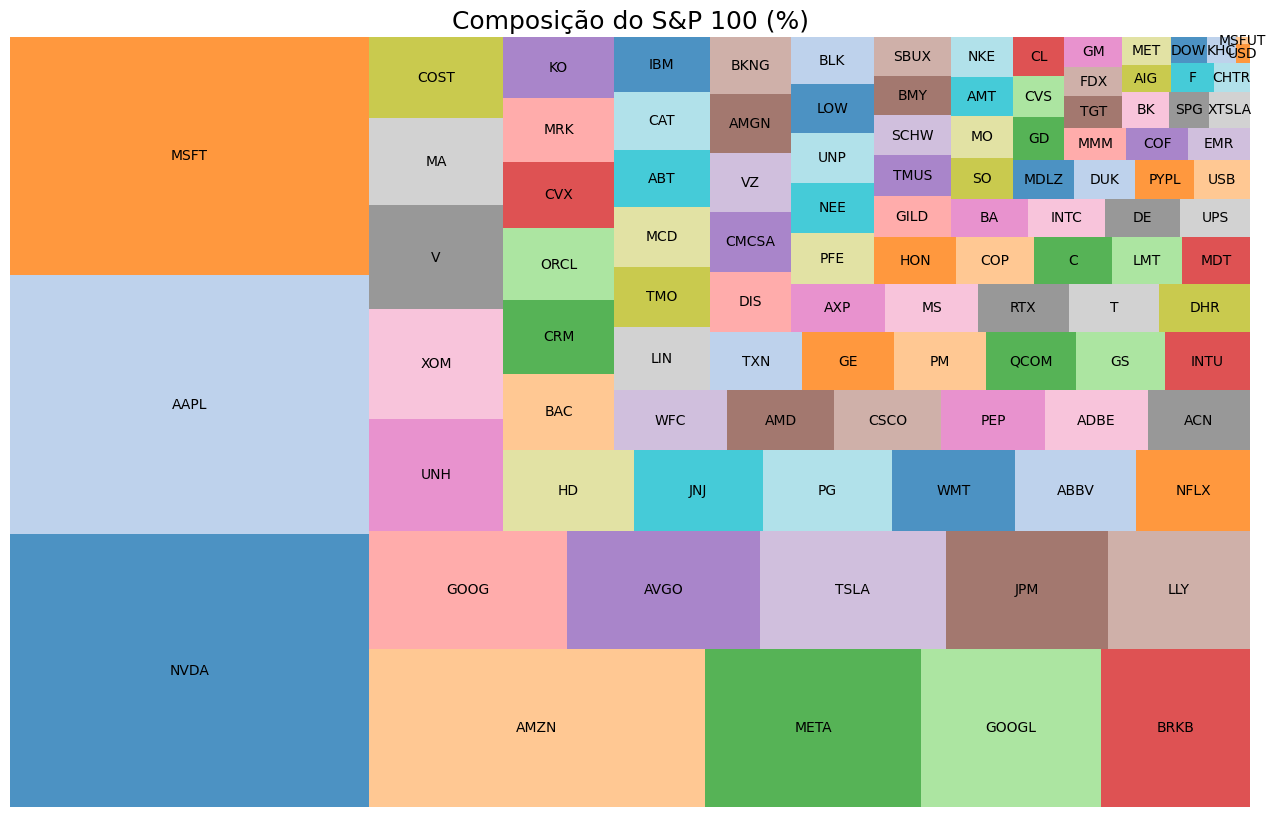

In [7]:
import matplotlib.pyplot as plt
import squarify

percentages_symbols['Weight (%)'] = percentages_symbols['Weight (%)'].replace({',': ''}, regex=True).astype(float)

returns_percentages_symbols = percentages_symbols[percentages_symbols['Weight (%)'] > 0]

fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor("white")

squarify.plot(
    sizes=returns_percentages_symbols['Weight (%)'],
    label=returns_percentages_symbols['Ticker'],
    alpha=0.8,
    color=plt.cm.tab20.colors
)

plt.axis('off')
plt.title("Composição do S&P 100 (%)", fontsize=18)
plt.show()

### Heatmap

DatetimeIndex(['2022-11-01 00:00:00+00:00', '2022-11-02 00:00:00+00:00',
               '2022-11-03 00:00:00+00:00', '2022-11-04 00:00:00+00:00',
               '2022-11-07 00:00:00+00:00', '2022-11-08 00:00:00+00:00',
               '2022-11-09 00:00:00+00:00', '2022-11-10 00:00:00+00:00',
               '2022-11-11 00:00:00+00:00', '2022-11-14 00:00:00+00:00',
               ...
               '2024-10-17 00:00:00+00:00', '2024-10-18 00:00:00+00:00',
               '2024-10-21 00:00:00+00:00', '2024-10-22 00:00:00+00:00',
               '2024-10-23 00:00:00+00:00', '2024-10-24 00:00:00+00:00',
               '2024-10-25 00:00:00+00:00', '2024-10-28 00:00:00+00:00',
               '2024-10-29 00:00:00+00:00', '2024-10-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=502, freq=None)


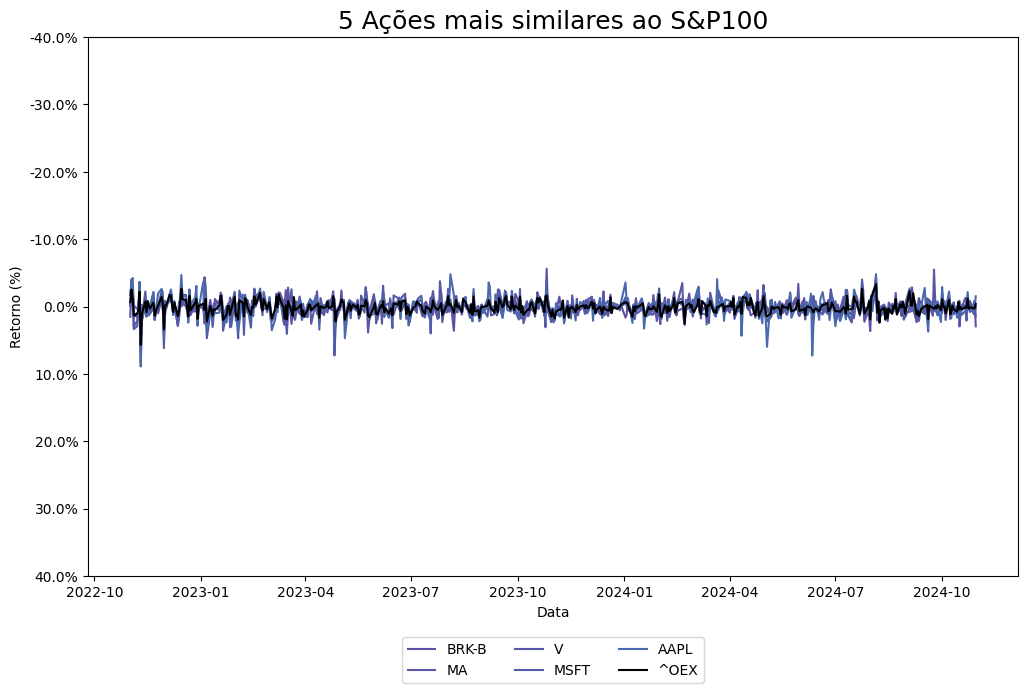

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular as diferenças e a intensidade
retorno_sp100_valor = retornos_sp100['^OEX']
diferencas = retornos_nasdaq_nyse.subtract(retorno_sp100_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

# Selecionar as 5 ações com maiores diferenças médias
top5_tickers = intensidade_media.nlargest(5).index

# Configurar o mapa de cores
cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

print(retornos_nasdaq_nyse.index)

# Plotar cada uma das 5 ações selecionadas com base na intensidade de cor
for column in top5_tickers:
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)
    plt.plot(retornos_nasdaq_nyse.index, retornos_nasdaq_nyse[column], color=color, linewidth=1.5, label=column)

plt.plot(retornos_sp100.index, retornos_sp100, label='^OEX', color='black', linewidth=1.5)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("5 Ações mais similares ao S&P100", fontsize=18)
plt.ylim(0.40, -0.40)
plt.show()

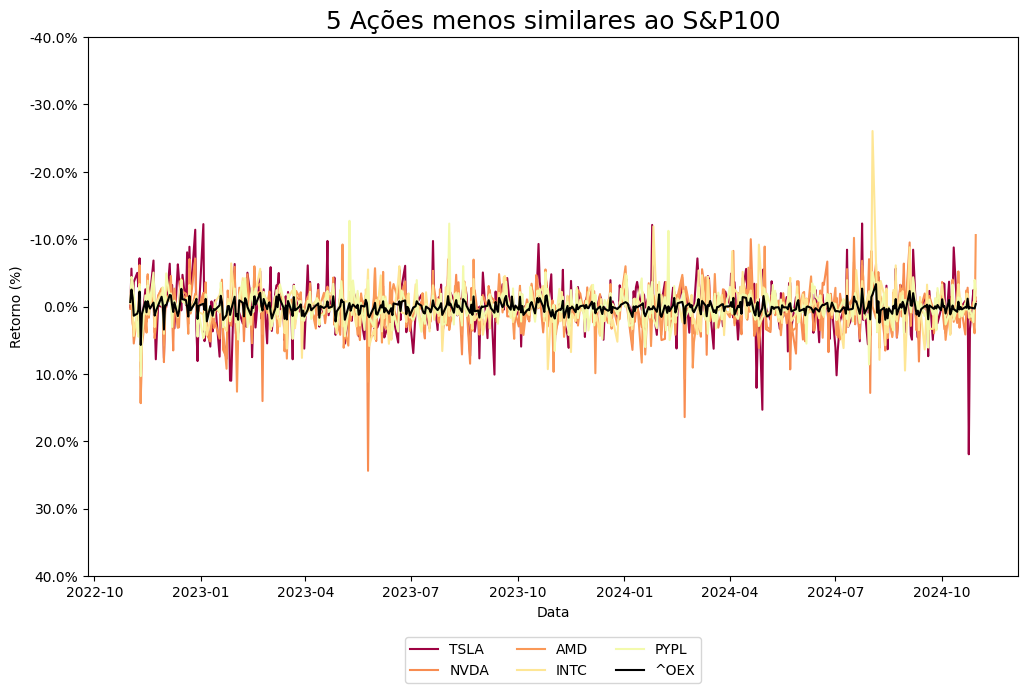

In [9]:
# Calcular as diferenças e a intensidade
retorno_sp100_valor = retornos_sp100['^OEX']
diferencas = retornos_nasdaq_nyse.subtract(retorno_sp100_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

# Selecionar as 5 ações com maiores diferenças médias
top5_tickers = intensidade_media.nsmallest(5).index

# Configurar o mapa de cores
cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

# Plotar cada uma das 5 ações selecionadas com base na intensidade de cor
for column in top5_tickers:
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)
    plt.plot(retornos_nasdaq_nyse.index, retornos_nasdaq_nyse[column], color=color, linewidth=1.5, label=column)

# Plotar o índice OEX
plt.plot(retornos_sp100.index, retornos_sp100, label='^OEX', color='black', linewidth=1.5)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("5 Ações menos similares ao S&P100", fontsize=18)
plt.ylim(0.40, -0.40)
plt.show()

#### 'Heatmap' com todas as ações

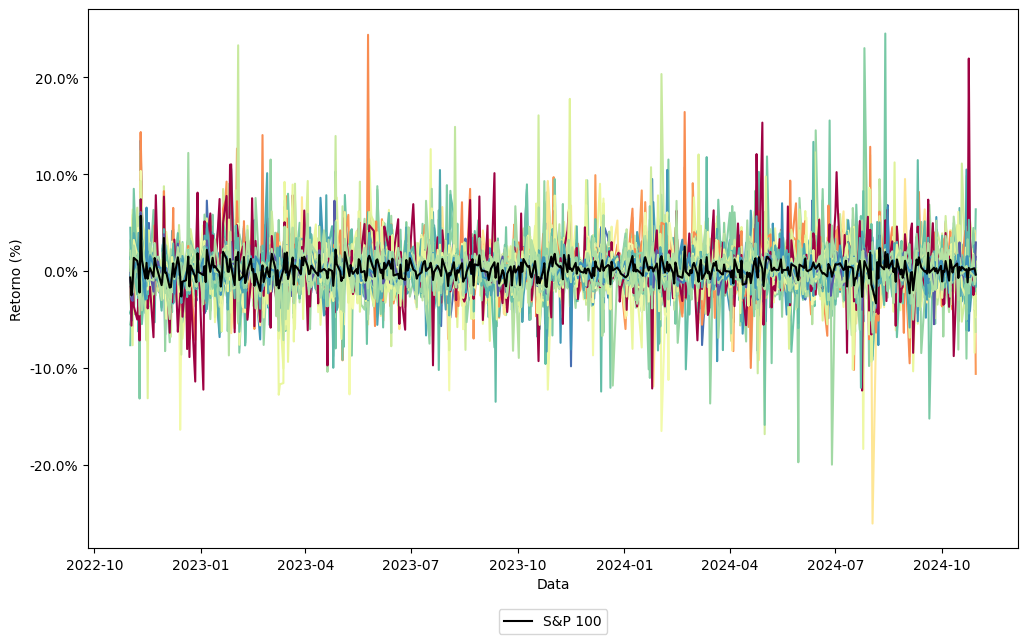

In [10]:
retorno_sp100_valor = retornos_sp100['^OEX']
diferencas = retornos_nasdaq_nyse.subtract(retorno_sp100_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

# Plotar cada ação com uma cor baseada na diferenca
for column in intensidade_media.index:
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)

    plt.plot(retornos_nasdaq_nyse.index, retornos_nasdaq_nyse[column], color=color, linewidth=1.5)

plt.plot(retornos_sp100.index, retornos_sp100, label='S&P 100', color='black', linewidth=1.5)

plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=12)
plt.show()

### Regressão linear

In [11]:
import statsmodels.formula.api as sm

print(sp100_dados)
sp100_dados_renamed = sp100_dados.rename(columns={'^OEX': 'Preco_Ajustado'})
sp100_dados_renamed['Indice'] = sp100_dados_renamed.index.astype(int) / 10**9
modelo_sp100 = sm.ols('Preco_Ajustado ~ Indice', data=sp100_dados_renamed).fit()
media_regressao_sp100 = modelo_sp100.predict(sp100_dados_renamed).mean()

Ticker                            ^OEX
Date                                  
2022-10-31 00:00:00+00:00  1740.510010
2022-11-01 00:00:00+00:00  1728.729980
2022-11-02 00:00:00+00:00  1685.180054
2022-11-03 00:00:00+00:00  1662.400024
2022-11-04 00:00:00+00:00  1684.890015
...                                ...
2024-10-24 00:00:00+00:00  2806.389893
2024-10-25 00:00:00+00:00  2809.850098
2024-10-28 00:00:00+00:00  2816.830078
2024-10-29 00:00:00+00:00  2824.739990
2024-10-30 00:00:00+00:00  2813.929932

[503 rows x 1 columns]


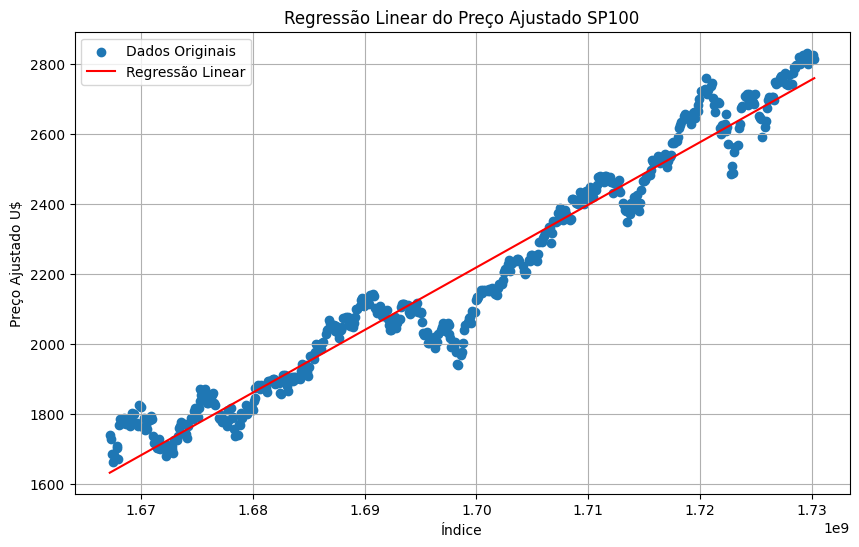

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(sp100_dados_renamed['Indice'], sp100_dados_renamed['Preco_Ajustado'], label='Dados Originais')
plt.plot(sp100_dados_renamed['Indice'], modelo_sp100.predict(sp100_dados_renamed), color='red', label='Regressão Linear')
plt.xlabel('Índice')
plt.ylabel('Preço Ajustado U$')
plt.title('Regressão Linear do Preço Ajustado SP100')
plt.legend()
plt.grid(True)
plt.show()

### Boxplot

<ipython-input-13-ff3a2fe45e85>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=sp100_dados_renamed['Preco_Ajustado'], palette='deep')


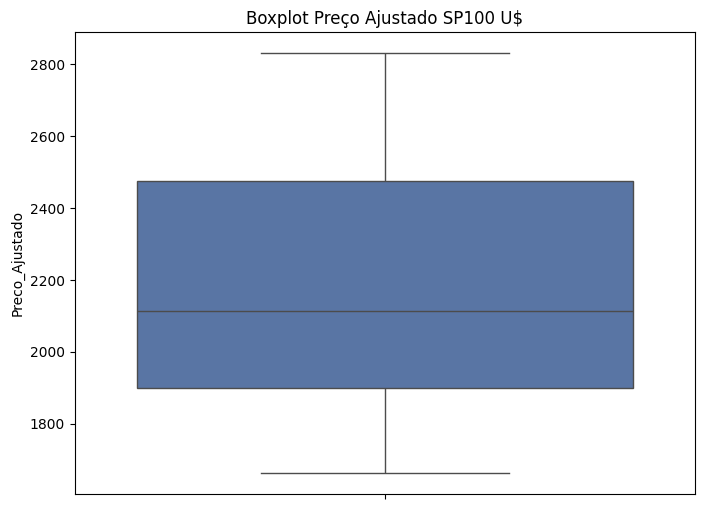

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

ibov_boxplot = plt.figure(figsize=(8, 6))
sns.boxplot(y=sp100_dados_renamed['Preco_Ajustado'], palette='deep')
plt.title('Boxplot Preço Ajustado SP100 U$')
plt.show()

### Comparação S&P100 e ações

## IBOV

### Inicializando

In [14]:
filepath = 'pre_processed_data/bkp_pre_processed_parsed_B3.csv'
start_date = dt.datetime(2022, 10, 31)
end_date = dt.datetime(2024, 10, 31)
tickers = []

with open(filepath, 'r') as file:
  for line in file:
    tickers.extend(line.strip().split(','))

ibov_percentages_symbols = pd.read_csv('pre_processed_data/IBOV_percentages_symbols.csv', encoding='latin-1')

# Obtendo dados dos ativos
dados_b3 = obter_dados(tickers, start_date, end_date)
dados_ibov = obter_dados(['^BVSP'], start_date, end_date)

# Calculando retornos
retornos_b3 = dados_b3.pct_change().dropna()
retornos_ibov = dados_ibov.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Not available in the period requested: []
Failed download: []
Not available in the period requested: []
Failed download: []


### Composição do IBOV

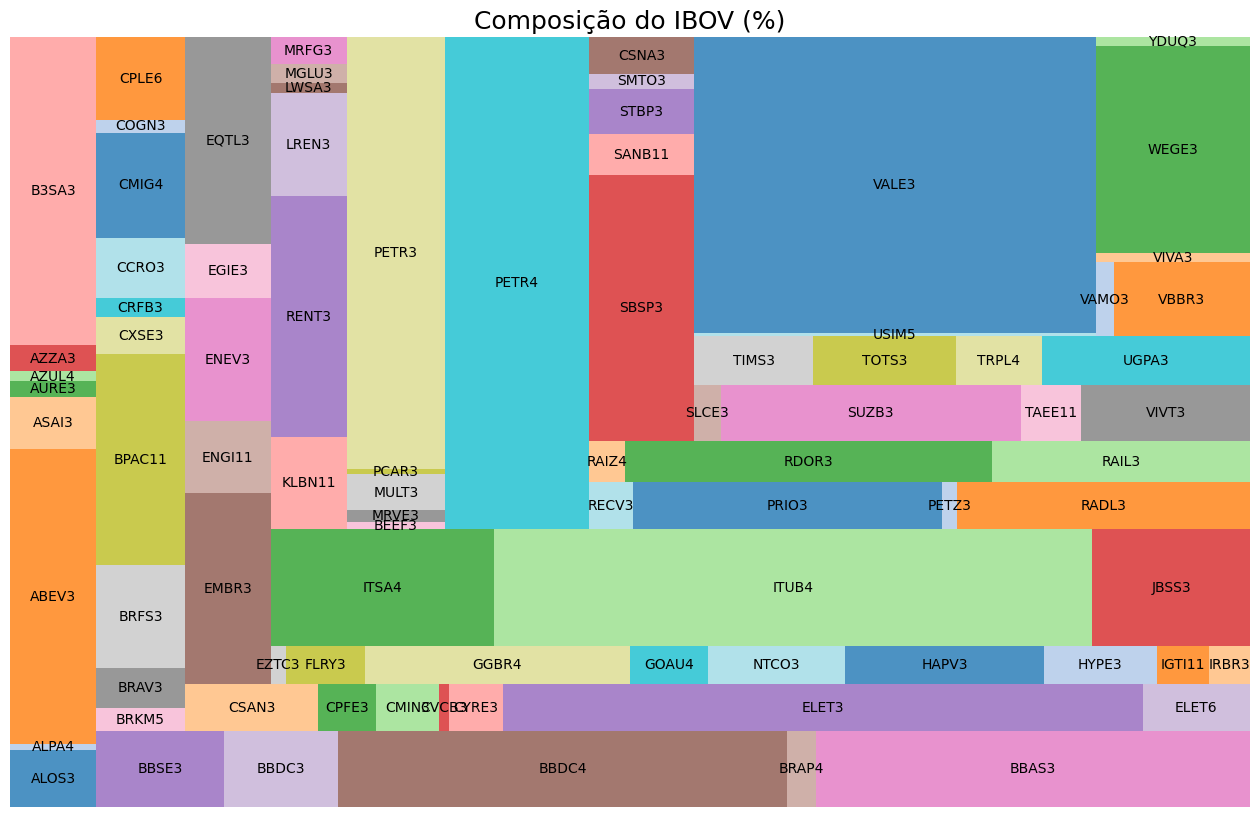

In [15]:
ibov_percentages_symbols['Part. (%)'] = ibov_percentages_symbols['Part. (%)'].replace({',': ''}, regex=True).astype(float)

returns_ibov_percentages_symbols = ibov_percentages_symbols[ibov_percentages_symbols['Part. (%)'] > 0]

fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor("white")

squarify.plot(
    sizes=returns_ibov_percentages_symbols['Part. (%)'],
    label=returns_ibov_percentages_symbols['Codigo'],
    alpha=0.8,
    color=plt.cm.tab20.colors
)

plt.axis('off')
plt.title("Composição do IBOV (%)", fontsize=18)
plt.show()

### Heatmap

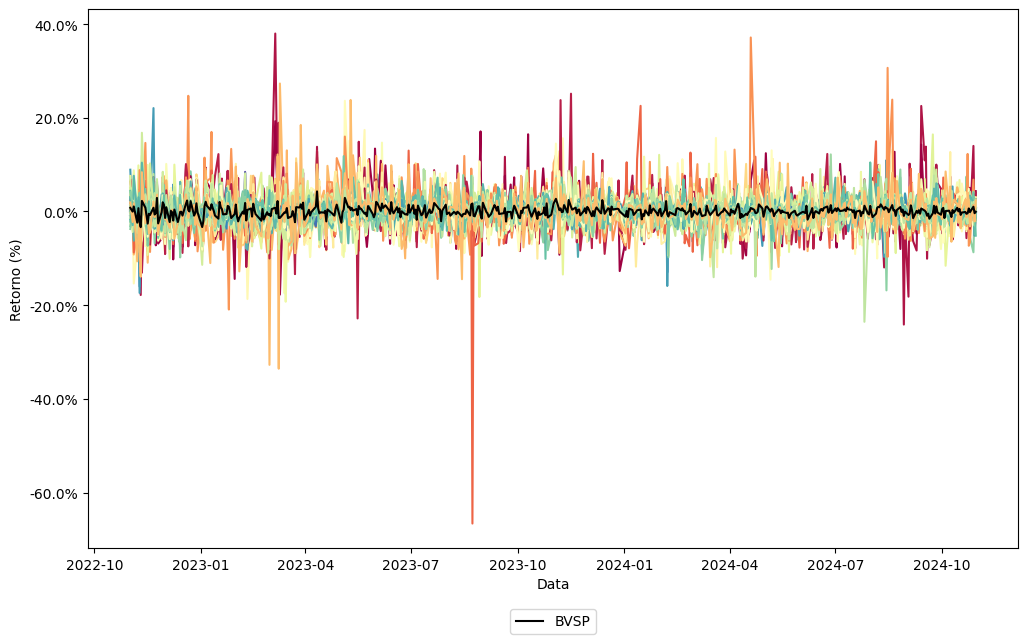

In [16]:
# Calcular as diferenças e a intensidade
retorno_ibov_valor = retornos_ibov['^BVSP']
diferencas = retornos_b3.subtract(retorno_ibov_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

# Plotar cada ação com uma cor baseada na diferenca
for i, column in enumerate(retornos_b3.columns):
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)

    plt.plot(retornos_b3.index, retornos_b3[column], color=color, linewidth=1.5)

plt.plot(retornos_ibov.index, retornos_ibov, label='BVSP', color='black', linewidth=1.5)

plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=12)
plt.show()

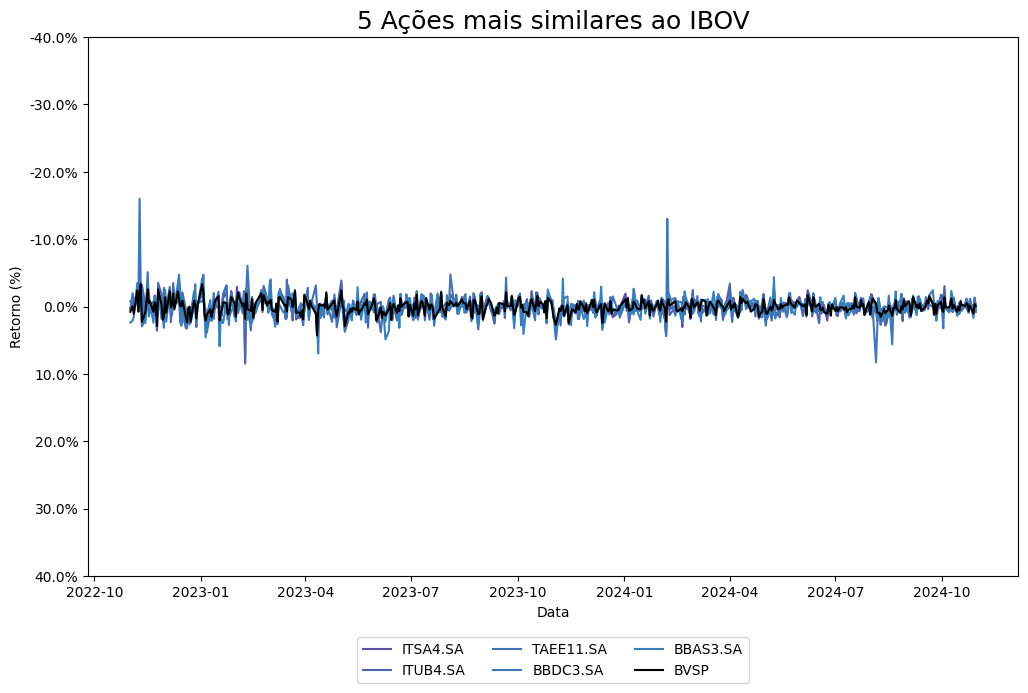

In [17]:
# Calcular as diferenças e a intensidade
retorno_ibov_valor = retornos_ibov['^BVSP']
diferencas = retornos_b3.subtract(retorno_ibov_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

# Selecionar as 5 ações com maiores diferenças médias
top5_tickers = intensidade_media.nlargest(5).index

# Configurar o mapa de cores
cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

# Plotar cada uma das 5 ações selecionadas com base na intensidade de cor
for column in top5_tickers:
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)
    plt.plot(retornos_b3.index, retornos_b3[column], color=color, linewidth=1.5, label=column)

plt.plot(retornos_ibov.index, retornos_ibov, label='BVSP', color='black', linewidth=1.5)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("5 Ações mais similares ao IBOV", fontsize=18)
plt.ylim(0.40, -0.40)
plt.show()

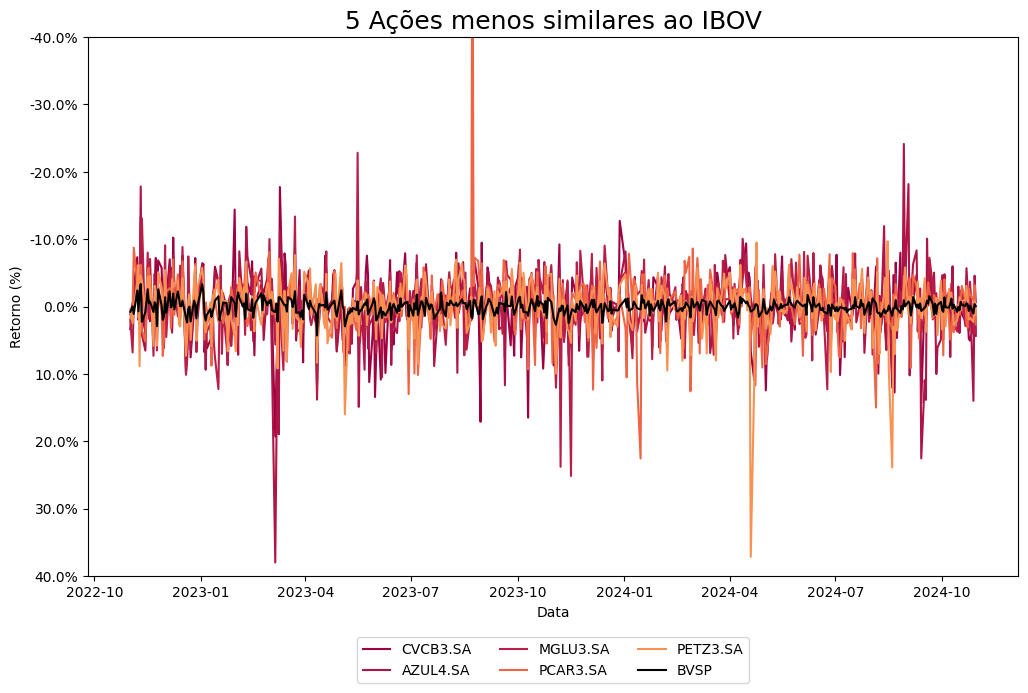

In [18]:
# Calcular as diferenças e a intensidade
retorno_ibov_valor = retornos_ibov['^BVSP']
diferencas = retornos_b3.subtract(retorno_ibov_valor, axis=0).abs()

# Normalizar as diferenças para obter uma intensidade entre 0 e 1
max_val = diferencas.max().max()
intensidade = (1 - (diferencas / max_val)) if max_val != 0 else 0

# Calcular a intensidade média para cada ticker
intensidade_media = intensidade.mean()
intensidade_min = intensidade_media.min()
intensidade_max = intensidade_media.max()
intensidade_media = (intensidade_media - intensidade_min) / (intensidade_max - intensidade_min)

# Selecionar as 5 ações com maiores diferenças médias
top5_tickers = intensidade_media.nsmallest(5).index

# Configurar o mapa de cores
cmap = plt.cm.Spectral
plt.figure(figsize=(12, 7))

# Plotar cada uma das 5 ações selecionadas com base na intensidade de cor
for column in top5_tickers:
    ticker_intensity = intensidade_media[column]
    color = cmap(ticker_intensity)
    plt.plot(retornos_b3.index, retornos_b3[column], color=color, linewidth=1.5, label=column)

# Plotar o índice BVSP
plt.plot(retornos_ibov.index, retornos_ibov, label='BVSP', color='black', linewidth=1.5)

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Retorno (%)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("5 Ações menos similares ao IBOV", fontsize=18)
plt.ylim(0.40, -0.40)
plt.show()

### Regressão Linear

In [19]:
# Obter os dados do IBOV e do S&P 100
dados_ibov_renamed = dados_ibov.rename(columns={'^BVSP': 'Preco_Ajustado'})

dados_ibov_renamed['Indice'] = dados_ibov_renamed.index.astype(int) / 10**9
modelo_ibov = sm.ols('Preco_Ajustado ~ Indice', data=dados_ibov_renamed).fit()
media_regressao_ibov = modelo_ibov.predict(dados_ibov_renamed).mean()

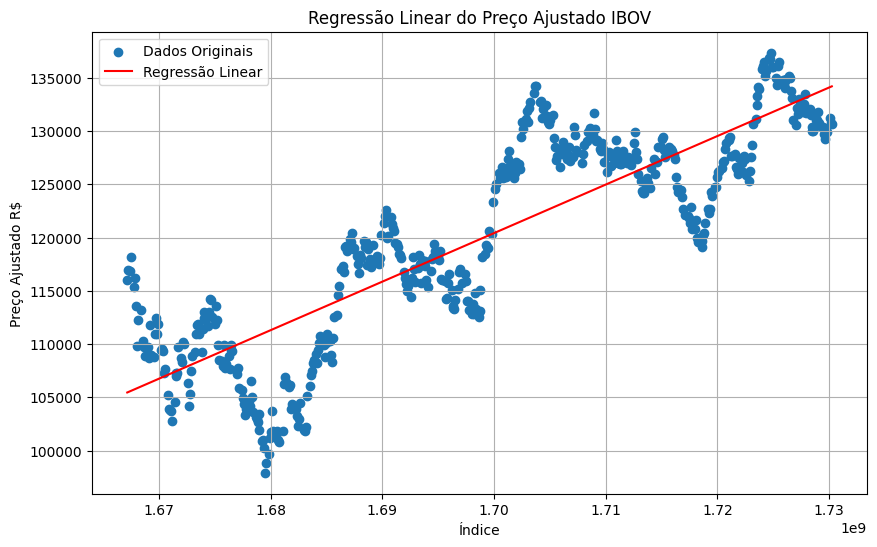

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(dados_ibov_renamed['Indice'], dados_ibov_renamed['Preco_Ajustado'], label='Dados Originais')
plt.plot(dados_ibov_renamed['Indice'], modelo_ibov.predict(dados_ibov_renamed), color='red', label='Regressão Linear')
plt.xlabel('Índice')
plt.ylabel('Preço Ajustado R$')
plt.title('Regressão Linear do Preço Ajustado IBOV')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


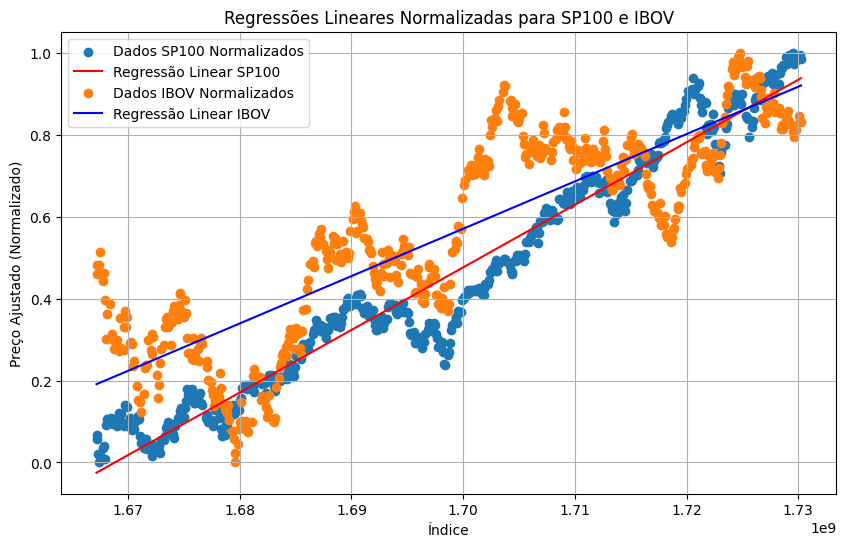

In [21]:
# Normalizar os dados
scaler_sp = MinMaxScaler()
scaler_ibov = MinMaxScaler()

# Normalizar os valores reais de Preco_Ajustado para ambos os índices
sp100_dados_renamed['Preco_Ajustado_Normalizado'] = scaler_sp.fit_transform(sp100_dados_renamed[['Preco_Ajustado']])
dados_ibov_renamed['Preco_Ajustado_Normalizado'] = scaler_ibov.fit_transform(dados_ibov_renamed[['Preco_Ajustado']])

# Normalizar as previsões das regressões lineares
sp100_pred_normalized = scaler_sp.transform(np.array(modelo_sp100.predict(sp100_dados_renamed)).reshape(-1, 1))
ibov_pred_normalized = scaler_ibov.transform(np.array(modelo_ibov.predict(dados_ibov_renamed)).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 6))

# Gráfico do SP100
plt.scatter(sp100_dados_renamed['Indice'], sp100_dados_renamed['Preco_Ajustado_Normalizado'], label='Dados SP100 Normalizados')
plt.plot(sp100_dados_renamed['Indice'], sp100_pred_normalized, color='red', label='Regressão Linear SP100')

# Gráfico do IBOV
plt.scatter(dados_ibov_renamed['Indice'], dados_ibov_renamed['Preco_Ajustado_Normalizado'], label='Dados IBOV Normalizados')
plt.plot(dados_ibov_renamed['Indice'], ibov_pred_normalized, color='blue', label='Regressão Linear IBOV')

# Configurações do gráfico
plt.xlabel('Índice')
plt.ylabel('Preço Ajustado (Normalizado)')
plt.title('Regressões Lineares Normalizadas para SP100 e IBOV')
plt.legend()
plt.grid(True)
plt.show()


### Boxplot

<ipython-input-22-106450ace150>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=dados_ibov_renamed['Preco_Ajustado'], palette="Set2")


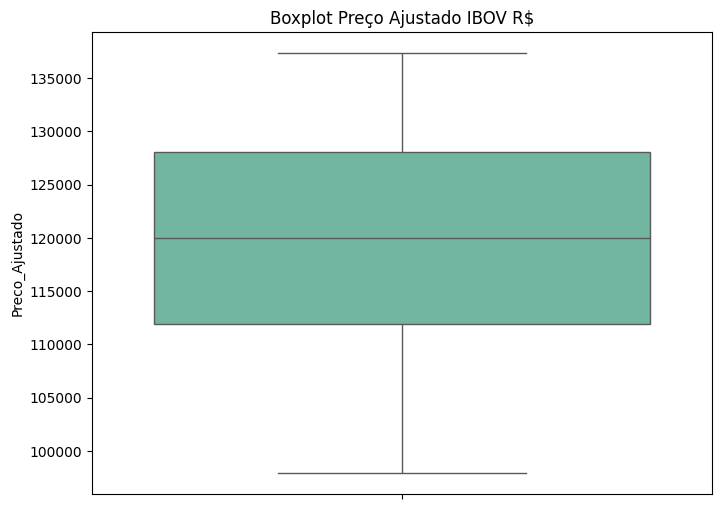

In [22]:
ibov_boxplot = plt.figure(figsize=(8, 6))
sns.boxplot(y=dados_ibov_renamed['Preco_Ajustado'], palette="Set2")
plt.title('Boxplot Preço Ajustado IBOV R$')
plt.show()

<ipython-input-23-8de89cc3b003>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dados_normalizados, x='Indice', y='Preco Ajustado Normalizado',palette='Set2')


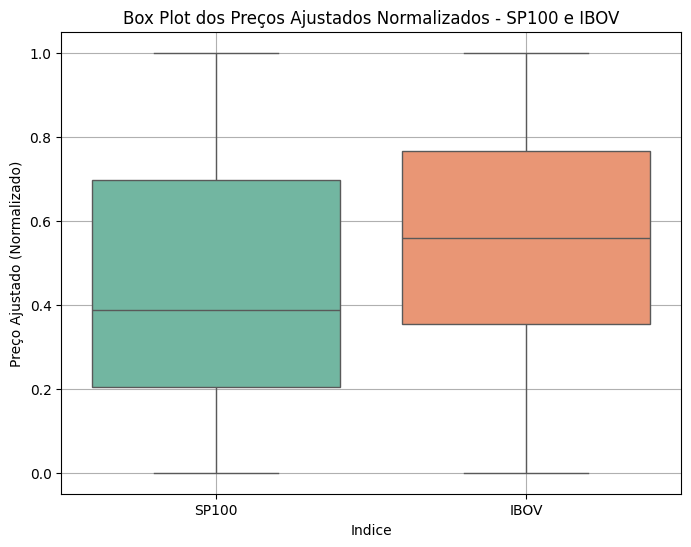

In [23]:
# Organizando os dados para o Seaborn
sp100_dados_renamed['Indice'] = 'SP100'
dados_ibov_renamed['Indice'] = 'IBOV'

# Concatenando os dados normalizados em um único DataFrame
dados_normalizados = pd.concat([
    sp100_dados_renamed[['Preco_Ajustado_Normalizado', 'Indice']],
    dados_ibov_renamed[['Preco_Ajustado_Normalizado', 'Indice']]
])

# Renomeando a coluna para um nome genérico
dados_normalizados = dados_normalizados.rename(columns={'Preco_Ajustado_Normalizado': 'Preco Ajustado Normalizado'})

# Criando o box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=dados_normalizados, x='Indice', y='Preco Ajustado Normalizado',palette='Set2')
plt.ylabel('Preço Ajustado (Normalizado)')
plt.title('Box Plot dos Preços Ajustados Normalizados - SP100 e IBOV')
plt.grid(True)
plt.show()

# Otimização de pesos

## S&P100

### Inicializando

In [58]:
filepath_sp100 = 'pre_processed_data/bkp_pre_processed_parsed_SP100.csv'
train_start_date = dt.datetime(2022, 10, 31)
train_end_date = dt.datetime(2023, 10, 31)
tickers = []

with open(filepath_sp100, 'r') as file:
  for line in file:
    tickers.extend(line.strip().split(','))

dados_nasdaq_nyse = obter_dados(tickers, train_start_date, train_end_date)
sp100_dados = obter_dados(['^OEX'], train_start_date, train_end_date)

returns_nasdaq_nyse = dados_nasdaq_nyse.pct_change().dropna()
returns_sp100 = sp100_dados.pct_change().dropna()


# dealing with missing values using previous value
combined_index = returns_nasdaq_nyse.index.union(returns_ibov.index).sort_values()

returns_nasdaq_nyse_full = returns_nasdaq_nyse.reindex(combined_index)
returns_sp100_full = returns_sp100.reindex(combined_index)

returns_nasdaq_nyse_full.ffill(inplace=True)
returns_sp100_full.ffill(inplace=True)

clear_output()

### Conseguindo pesos

In [59]:
weights_dict = {}
for k in n_k:
    selected_stocks, optimized_weights = get_weights(returns_nasdaq_nyse_full, returns_sp100_full, k)
    weights_dict[f"selected_stocks_{k}"] = selected_stocks
    weights_dict[f"optimized_weights_{k}"] = optimized_weights

clear_output()
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    print(f"Selected stocks and optimized weights for k = {k}:")
    for stock, weight in zip(selected_stocks, optimized_weights):
        print(f"{stock} - {weight * 100:.2f}%")

Selected stocks and optimized weights for k = 10:
AAPL - 12.13%
AMZN - 8.65%
BMY - 8.36%
BRK-B - 22.38%
GD - 8.22%
GOOG - 5.35%
MSFT - 10.87%
NVDA - 4.79%
PM - 10.30%
TXN - 8.94%
Selected stocks and optimized weights for k = 15:
AAPL - 11.08%
AMZN - 6.59%
BMY - 5.56%
BRK-B - 15.41%
CAT - 4.37%
CL - 6.73%
GOOG - 6.65%
LMT - 4.74%
MSFT - 11.88%
NVDA - 4.17%
TSLA - 2.43%
TXN - 6.59%
USB - 3.25%
VZ - 4.40%
WMT - 6.13%
Selected stocks and optimized weights for k = 30:
AAPL - 10.22%
ADBE - 1.79%
AMGN - 2.35%
AMZN - 4.68%
AVGO - 2.56%
BK - 2.42%
BRK-B - 6.25%
CAT - 1.95%
COP - 2.41%
CRM - 1.20%
GOOG - 5.76%
HD - 2.54%
INTC - 0.99%
JPM - 4.49%
LLY - 1.87%
MDT - 2.50%
META - 1.72%
MO - 3.50%
MSFT - 9.76%
NVDA - 3.01%
PEP - 4.68%
PFE - 2.86%
SCHW - 1.16%
TMO - 2.35%
TSLA - 2.10%
TXN - 2.40%
UNH - 2.62%
V - 3.25%
VZ - 2.89%
WMT - 3.72%


### Métricas (em desenvolvimento)

[7.736221302316848e-06]
[7.736221302316848e-06, 5.650352938137199e-06]
[7.736221302316848e-06, 5.650352938137199e-06, 3.268366682462281e-06]


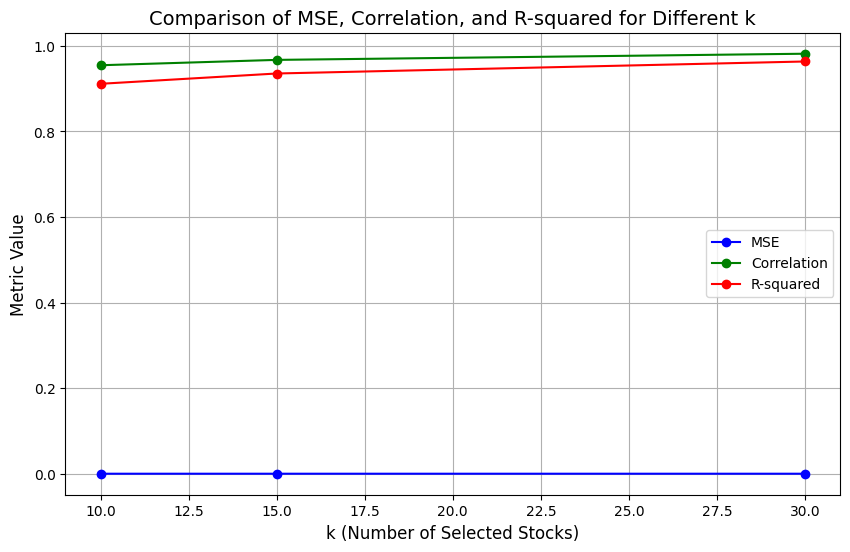

In [93]:
# Initialize lists to store the metrics for each k
mse_list = []
correlation_list = []
r_squared_list = []

# Loop over the values of k and compute metrics
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    # Compute the metrics for the current k
    mse, correlation, r_squared = compute_metrics(
        returns_sp100_long,  # Index returns
        returns_nasdaq_nyse_long,  # Stocks returns (returns_ex)
        selected_stocks,
        optimized_weights,
        k
    )

    # Append the computed metrics to the lists
    mse_list.append(mse)
    correlation_list.append(correlation)
    r_squared_list.append(r_squared)
    print(mse_list)

# After the loop, call the plotting function to visualize the results
plot_metrics(mse_list, correlation_list, r_squared_list, n_k)


### Plot de desempenho

In [71]:
test_start_date = dt.datetime(2022, 10, 31)
test_end_date = dt.datetime(2024, 10, 31)

dados_nasdaq_nyse_long = obter_dados(tickers, test_start_date, test_end_date)
sp100_dados_long = obter_dados(['^OEX'], test_start_date, test_end_date)

returns_nasdaq_nyse_long = dados_nasdaq_nyse_long.pct_change().dropna()
returns_sp100_long = sp100_dados_long.pct_change().dropna()

clear_output()

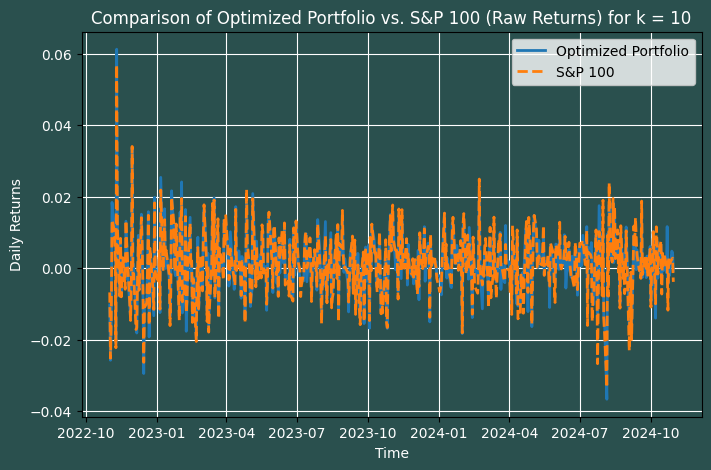

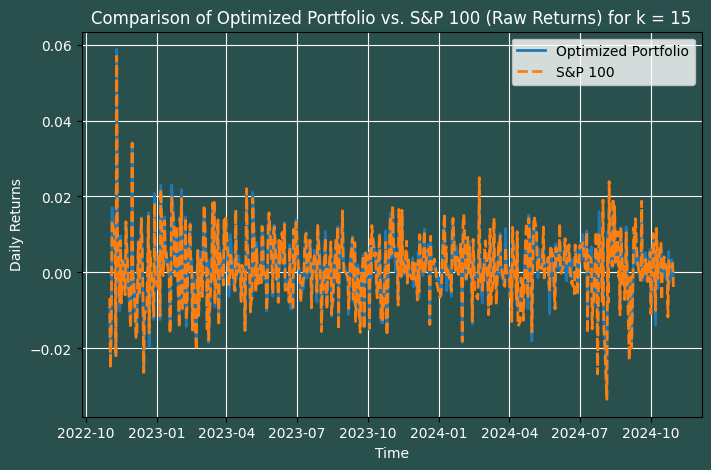

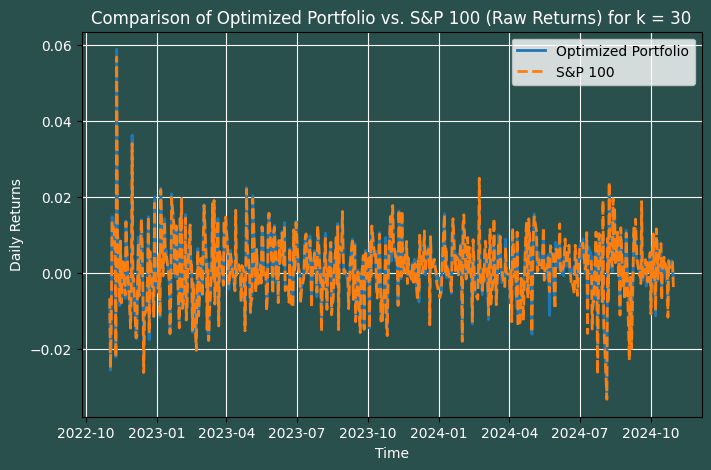

In [107]:
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    plot_portfolio_performance(selected_stocks, optimized_weights, returns_nasdaq_nyse_long, returns_sp100_long, k, "^OEX", "S&P 100")

### Composição da carteira otimizada

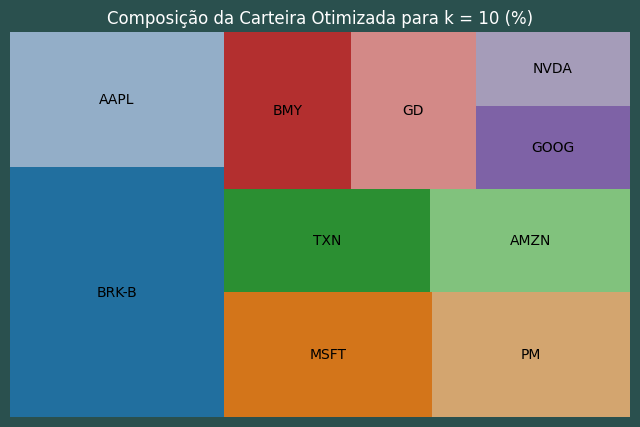

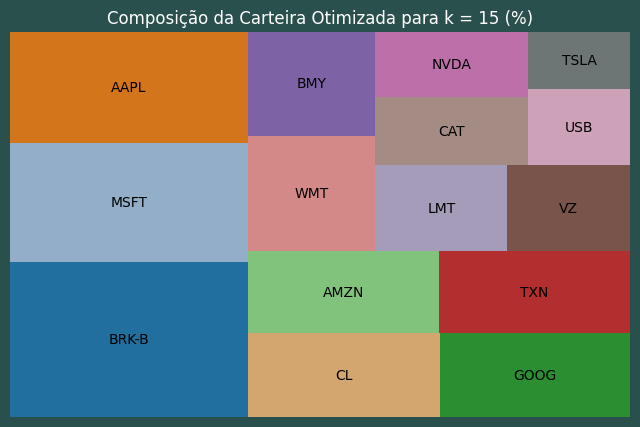

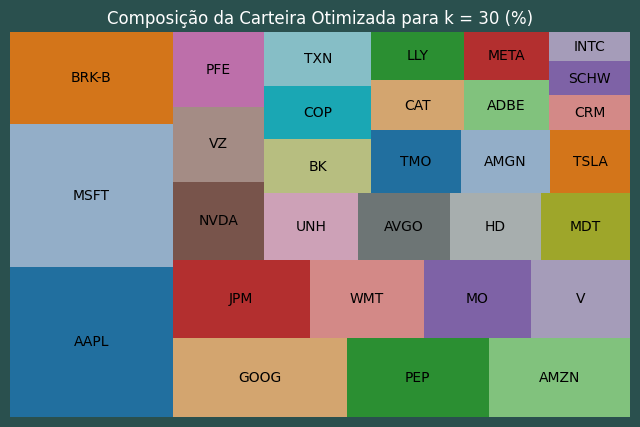

In [62]:
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    plot_portfolio_composition(selected_stocks, optimized_weights, k)

## IBOV

### Inicializando

In [11]:
filepath = 'pre_processed_data/bkp_pre_processed_parsed_B3.csv'
train_start_date = dt.datetime(2022, 10, 31)
train_end_date = dt.datetime(2023, 10, 31)
tickers = []

with open(filepath, 'r') as file:
  for line in file:
    tickers.extend(line.strip().split(','))

dados_b3 = obter_dados(tickers, train_start_date, train_end_date)
dados_ibov = obter_dados(['^BVSP'], train_start_date, train_end_date)

returns_b3 = dados_b3.pct_change().dropna()
returns_ibov = dados_ibov.pct_change().dropna()

# dealing with missing values using previous value
combined_index = returns_b3.index.union(returns_ibov.index).sort_values()

returns_b3_full = returns_b3.reindex(combined_index)
returns_ibov_full = returns_ibov.reindex(combined_index)

returns_b3_full.ffill(inplace=True)
returns_ibov_full.ffill(inplace=True)

clear_output()

### Conseguindo pesos

In [12]:
weights_dict = {}
for k in n_k:
    print(returns_b3_full.shape)
    selected_stocks, optimized_weights = get_weights(returns_b3_full, returns_ibov_full, k)
    weights_dict[f"selected_stocks_{k}"] = selected_stocks
    weights_dict[f"optimized_weights_{k}"] = optimized_weights

clear_output()
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    print(f"Selected stocks and optimized weights for k = {k}:")
    for stock, weight in zip(selected_stocks, optimized_weights):
        print(f"{stock} - {weight * 100:.2f}%")

Selected stocks and optimized weights for k = 10:
B3SA3.SA - 7.80%
ELET3.SA - 10.96%
HYPE3.SA - 6.31%
ITUB4.SA - 17.25%
KLBN11.SA - 7.84%
PETR3.SA - 13.24%
UGPA3.SA - 5.54%
VALE3.SA - 17.42%
VIVA3.SA - 7.84%
WEGE3.SA - 5.79%
Selected stocks and optimized weights for k = 15:
B3SA3.SA - 6.20%
BBDC3.SA - 6.52%
BPAC11.SA - 3.88%
ELET3.SA - 8.69%
GGBR4.SA - 4.45%
HAPV3.SA - 1.11%
ITUB4.SA - 10.54%
KLBN11.SA - 5.53%
PETR4.SA - 12.47%
SBSP3.SA - 4.02%
VIVT3.SA - 6.04%
UGPA3.SA - 4.59%
VALE3.SA - 15.00%
VIVA3.SA - 5.88%
WEGE3.SA - 5.08%
Selected stocks and optimized weights for k = 30:
ABEV3.SA - 3.50%
ASAI3.SA - 1.99%
AZUL4.SA - 0.00%
B3SA3.SA - 4.77%
BBDC3.SA - 6.49%
BBAS3.SA - 2.75%
BRFS3.SA - 0.96%
BPAC11.SA - 2.93%
CMIN3.SA - 1.47%
CVCB3.SA - 0.57%
ELET3.SA - 5.79%
ENEV3.SA - 1.64%
GGBR4.SA - 3.95%
HAPV3.SA - 1.02%
ITUB4.SA - 7.65%
JBSS3.SA - 1.75%
RENT3.SA - 3.37%
LREN3.SA - 1.32%
PCAR3.SA - 0.14%
PETR3.SA - 4.63%
PETR4.SA - 7.37%
PRIO3.SA - 2.29%
SBSP3.SA - 2.58%
SUZB3.SA - 2.28%
TAEE11

### Plot de desempenho

In [ ]:
test_start_date = dt.datetime(2022, 10, 31)
test_end_date = dt.datetime(2024, 10, 31)

dados_b3_long = obter_dados(tickers, test_start_date, test_end_date)
ibov_dados_long = obter_dados(['^BVSP'], test_start_date, test_end_date)

clear_output()

returns_b3_long = dados_b3_long.pct_change().dropna()
returns_ibov_long = ibov_dados_long.pct_change().dropna()

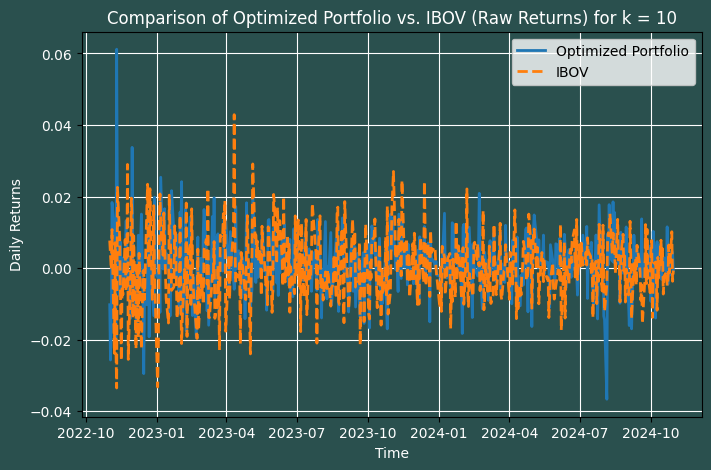

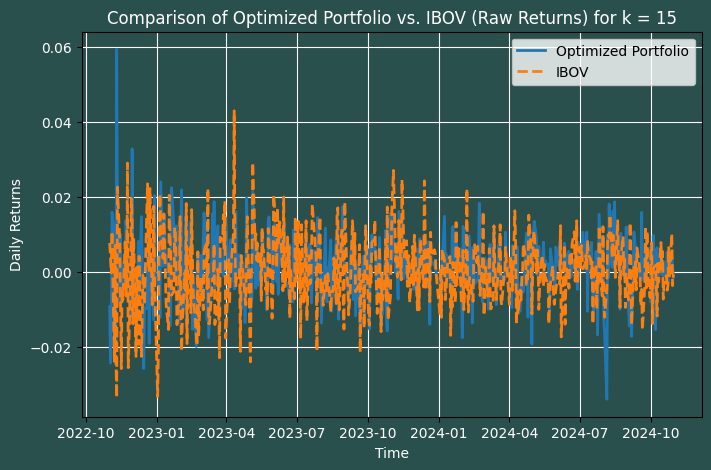

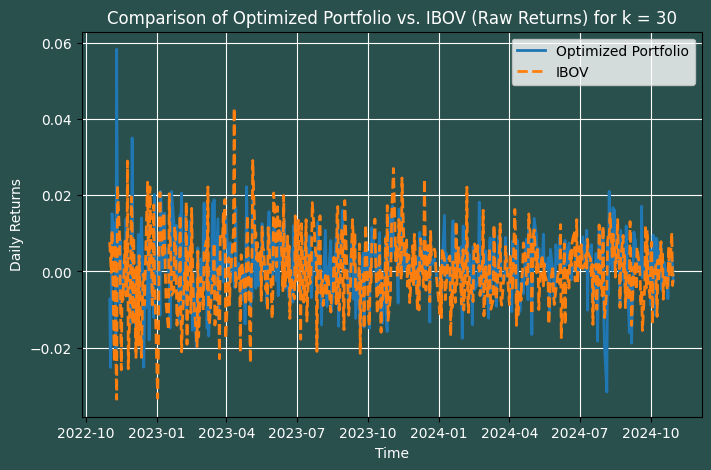

In [53]:
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    plot_portfolio_performance(selected_stocks, optimized_weights, returns_b3_long, returns_ibov_long, k, "^BVSP", "IBOV")

### Composição da carteira otimizada

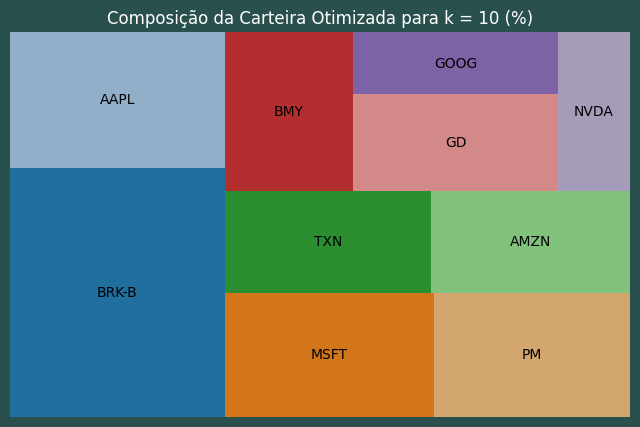

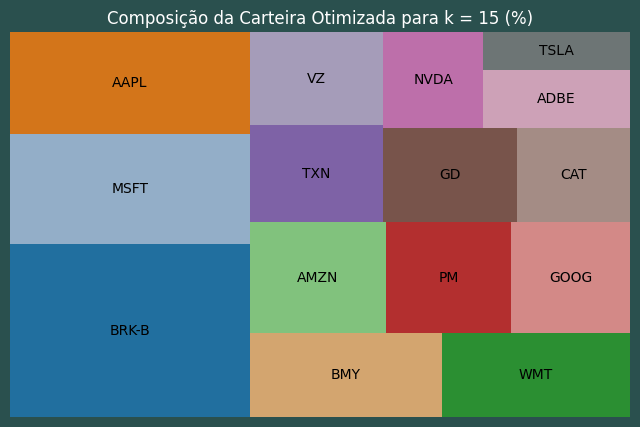

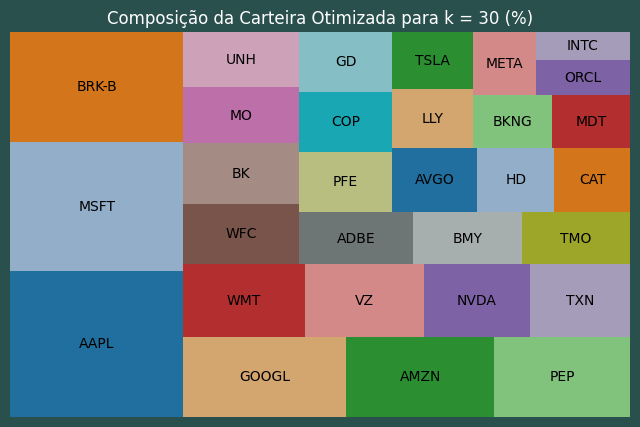

In [54]:
for k in n_k:
    selected_stocks = weights_dict.get(f"selected_stocks_{k}")
    optimized_weights = weights_dict.get(f"optimized_weights_{k}")

    plot_portfolio_composition(selected_stocks, optimized_weights, k)